In [2]:
#Mount Drive
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
#Import Libraries
import tensorflow as tf
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense

In [3]:
def preprocess_data(file_path):
  """function that preprocesses the data from the dataset"""
  df = pd.read_csv(file_path)
  # Remove all NaN-containing entries
  df = df.dropna()
  # Reformat the timestamp
  df['Timestamp'] = pd.to_datetime(df['Timestamp'],
  infer_datetime_format=True, unit='s')
  # Use the timestamp as index column
  df = df.set_index('Timestamp')
  # Narrow the scope of dataframe columns to work with
  df = df.drop(['Low', 'High', 'Volume_(BTC)', 'Weighted_Price'], 
               axis=1)
  # Reorder columns
  df = df.reindex(columns=['Open', 'Close', 'Volume_(Currency)'])
  # Work on a 1hour window
  df['Open'] = df['Open'].resample('1H').first()
  df['Close'] = df['Close'].resample('1H').last()
  df['Volume_(Currency)'] = df['Volume_(Currency)'].resample('1H').sum()
  # Remove all NaN-containing entries
  df = df.dropna()
  # Remove the first half of the dataframe (given data sparsity)
  df = df.iloc[-int((df.shape[0]/2)):]
  print(df.head(10))
  print('=======================')
  # Create the dataset (np.ndarray of "df.shape")
  dataset = df.values
  print(dataset[:10])
  print(dataset.shape)
  print('=======================')
  # Standardize the dataset
  mean = np.mean(dataset, axis=0)
  stddev = np.std(dataset, axis=0)
  dataset = (dataset - mean) / stddev
  print(dataset[:10])
  print(dataset.shape)
  print('=======================')
  def split_sequence(sequence, n_steps):
    """function that splits a dataset sequence into input data and
    labels"""
    X, Y = [], []
    for i in range(sequence.shape[0]):
      if (i + n_steps) >= sequence.shape[0]:
        break
      # Divide sequence between data (input) and labels (output)
      seq_X, seq_Y = sequence[i: i + n_steps],sequence[i + n_steps, -2]
      X.append(seq_X)
      Y.append(seq_Y)
    return np.array(X), np.array(Y)
  # Create training and validation datasets
  dataset_size = dataset.shape[0]
  x_train, y_train = split_sequence(dataset[0: math.ceil(0.7 *
                                    dataset_size)], 24)
  x_val, y_val = split_sequence(dataset[math.floor(0.7 *
                                dataset_size):], 24)
  return dataset, df, x_train, y_train, x_val, y_val

file_path = '/content/drive/MyDrive/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
dataset, df, x_train, y_train, x_val, y_val = preprocess_data(file_path)
print("dataset.shape: {}".format(dataset.shape))
print("df.shape: {}".format(df.shape))
print("x_train.shape: {}".format(x_train.shape))
print("y_train.shape: {}".format(y_train.shape))
print("x_val.shape: {}".format(x_val.shape))
print("y_val.shape: {}".format(y_val.shape))
print('=======================')


                       Open   Close  Volume_(Currency)
Timestamp                                             
2014-12-15 14:00:00  352.43  351.41       76563.109728
2014-12-15 15:00:00  351.45  352.24      189776.326565
2014-12-15 16:00:00  352.01  351.84      160460.690026
2014-12-15 17:00:00  351.86  351.79       91150.444060
2014-12-15 18:00:00  351.78  351.86       74268.655901
2014-12-15 19:00:00  351.80  350.26      269906.311900
2014-12-15 20:00:00  349.75  349.54      317987.897508
2014-12-15 21:00:00  349.46  348.29      307455.817859
2014-12-15 22:00:00  348.30  349.02      153848.372030
2014-12-15 23:00:00  349.02  349.00       83171.055565
[[   352.43          351.41        76563.10972834]
 [   351.45          352.24       189776.32656524]
 [   352.01          351.84       160460.69002644]
 [   351.86          351.79        91150.44405979]
 [   351.78          351.86        74268.65590146]
 [   351.8           350.26       269906.31189958]
 [   349.75          349.54       

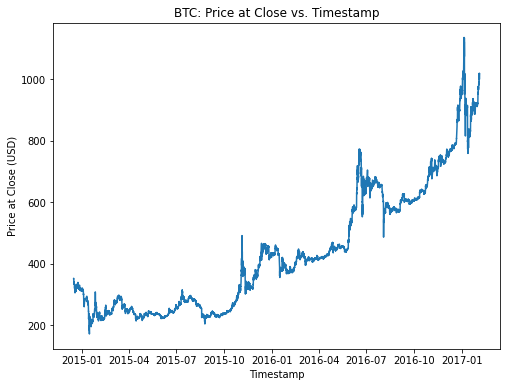

In [4]:
def plot_0(df, title):
  """function that plots Price at Close vs. Timestamp"""
  plt.figure(figsize=(8,6))
  plt.plot(df)
  plt.title(title)
  plt.xlabel('Timestamp')
  plt.ylabel('Price at Close (USD)')

  plt.show()
plot_0(df['Close'], 'BTC: Price at Close vs. Timestamp')

In [23]:
batch_size = 256
buffer_size = x_train.shape[0]
# Provide an infinite dataset
train_iterator = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).repeat()

In [26]:
#Build Model
n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
# Define the model
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='relu', input_shape=(n_steps, n_features))))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [28]:
epochs = 10
steps_per_epoch = 100
validation_steps = 10
# Train with an infinite dataset
history = model.fit(train_iterator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_iterator,
                    validation_steps=validation_steps)
print('=======================')
model.save("multivariate.h5")
model.summary()

Epoch 1/10
100/100 [==============================] - 9s 92ms/step - loss: 3.0689e-04 - val_loss: 0.0048
Epoch 2/10
100/100 [==============================] - 9s 90ms/step - loss: 3.0003e-04 - val_loss: 0.0077
Epoch 3/10
100/100 [==============================] - 9s 90ms/step - loss: 2.9878e-04 - val_loss: 0.0041
Epoch 4/10
100/100 [==============================] - 9s 92ms/step - loss: 2.7758e-04 - val_loss: 0.0036
Epoch 5/10
100/100 [==============================] - 9s 94ms/step - loss: 2.6554e-04 - val_loss: 0.0034
Epoch 6/10
100/100 [==============================] - 9s 95ms/step - loss: 2.5753e-04 - val_loss: 0.0045
Epoch 7/10
100/100 [==============================] - 9s 93ms/step - loss: 2.6110e-04 - val_loss: 0.0038
Epoch 8/10
100/100 [==============================] - 9s 91ms/step - loss: 2.4437e-04 - val_loss: 0.0037
Epoch 9/10
100/100 [==============================] - 9s 93ms/step - loss: 2.3915e-04 - val_loss: 0.0058
Epoch 10/10
100/100 [==============================] - 

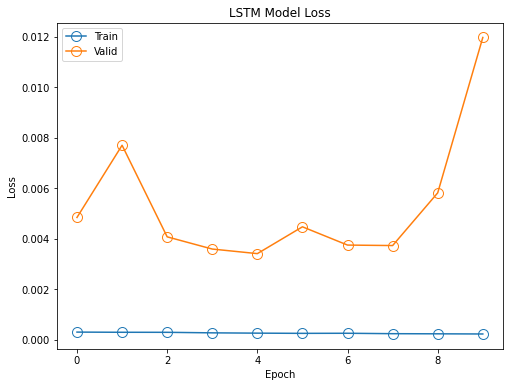

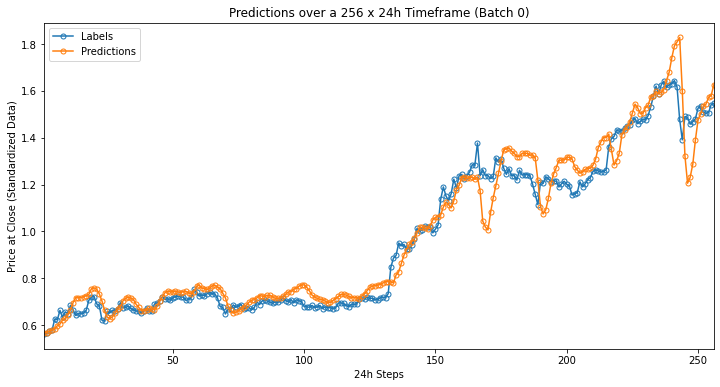

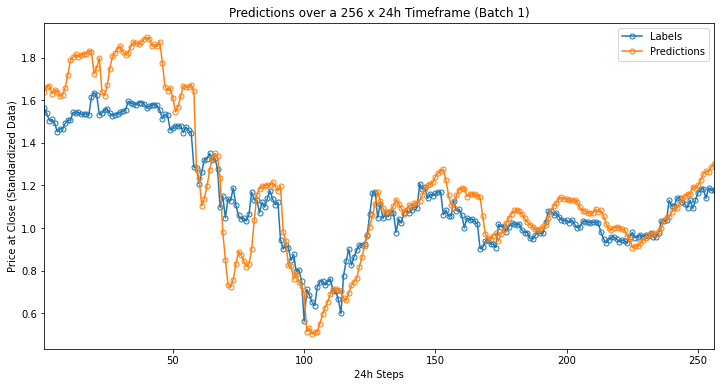

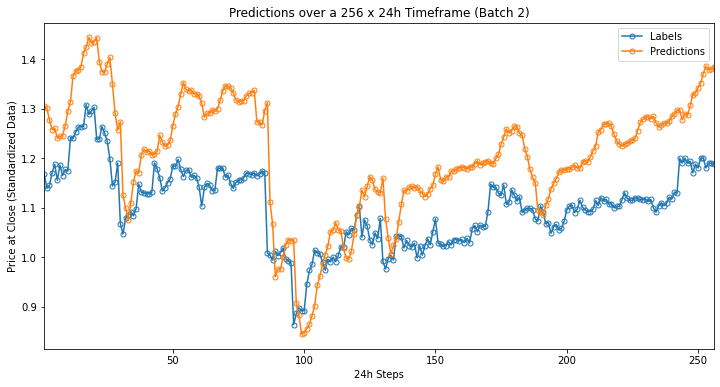

In [41]:
#Plot Grafik
def plot_1(history, title):
  """function that plots the loss results of the model"""
  plt.figure(figsize=(8,6))
  plt.plot(history.history['loss'], 'o-', mfc='none', markersize=10, 
  label='Train')
  plt.plot(history.history['val_loss'], 'o-', mfc='none', 
  markersize=10, label='Valid')
  plt.title('LSTM Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_2(data_24h, single_label, single_prediction, title):
  """function that plots a single-step price prediction following 
  24h of data"""
  time_steps = list(range(24))
  next_step = 24
  plt.figure(figsize=(8, 6))
  plt.plot(time_steps, data_24h, 'o-', markersize=8, 
  label='data_24h')
  plt.plot(next_step, single_label, 'b+', mfc='none', markersize=12, 
  label='Label')
  plt.plot(next_step, single_prediction, 'ro', mfc='none', 
  markersize=12, label='Prediction')
  plt.title(title)
  plt.xlabel('Time Steps')
  plt.ylabel('Price at Close (Standardized Data)')
  plt.legend()
  plt.show
def plot_3(future, prediction, title):
  """function that plots predictions over "batch_size" x 24h 
  timeframes"""
  days = list(range(1, future.shape[0] + 1))
  plt.figure(figsize=(12, 6))
  plt.plot(days, future, 'o-', markersize=5, mfc='none', 
  label='Labels')
  plt.plot(days, prediction, 'o-', markersize=5, mfc='none', 
  label='Predictions')
  plt.title(title)
  plt.xlim([days[0], days[-1]])
  plt.xlabel('24h Steps')
  plt.ylabel('Price at Close (Standardized Data)')
  plt.legend()
  plt.show
# Plot the model loss results
plot_1(history, 'Training / Validation Losses from History')
# Make a single-step price prediction following 24h of data
window_num = 0
# Make predictions over "batch_size" x 24h timeframes
string = 'Predictions over a {} x 24h Timeframe (Batch {})'
for batch_num, (x, y) in enumerate(val_iterator.take(3)):
  title = string.format(batch_size, batch_num)
  plot_3(y.numpy(),
         model.predict(x).reshape(-1),
         title)
  batch_num += 1